In [1]:
!pip install colorama

In [2]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb

print("All modules have been imported")

All modules have been imported


In [3]:
info=pd.read_csv("/content/drive/MyDrive/archive/Info.txt",sep=" ")
info=info.drop('Unnamed: 7',axis=1)
info.SEVERITY.fillna(0)

0      B
1      B
2      0
3      0
4      B
      ..
325    0
326    0
327    0
328    0
329    0
Name: SEVERITY, Length: 330, dtype: object

<Axes: ylabel='CLASS'>

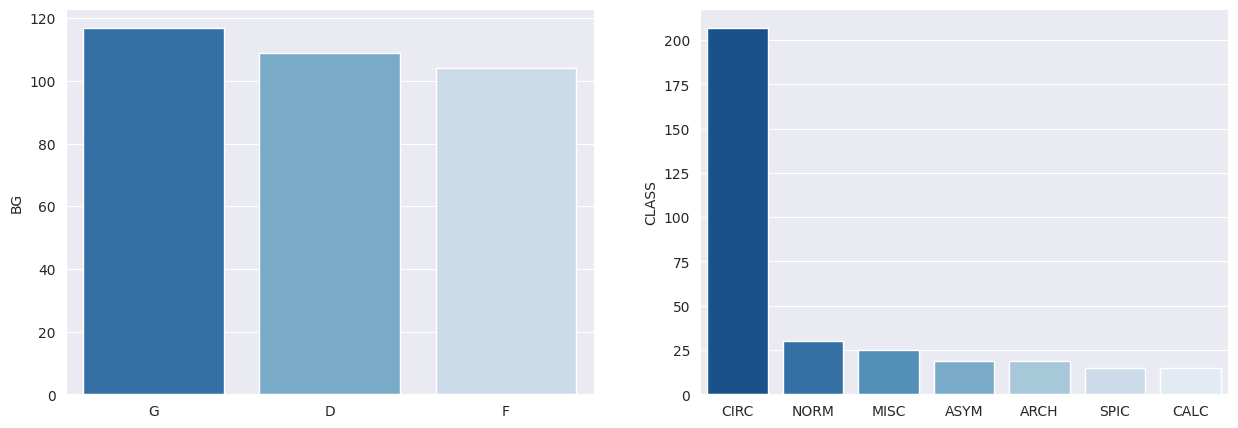

In [4]:
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x=info.BG.unique(),y=info.BG.value_counts(),palette='Blues_r',ax=ax1)
sns.barplot(x=info.CLASS.unique(),y=info.CLASS.value_counts(),palette='Blues_r',ax=ax2)

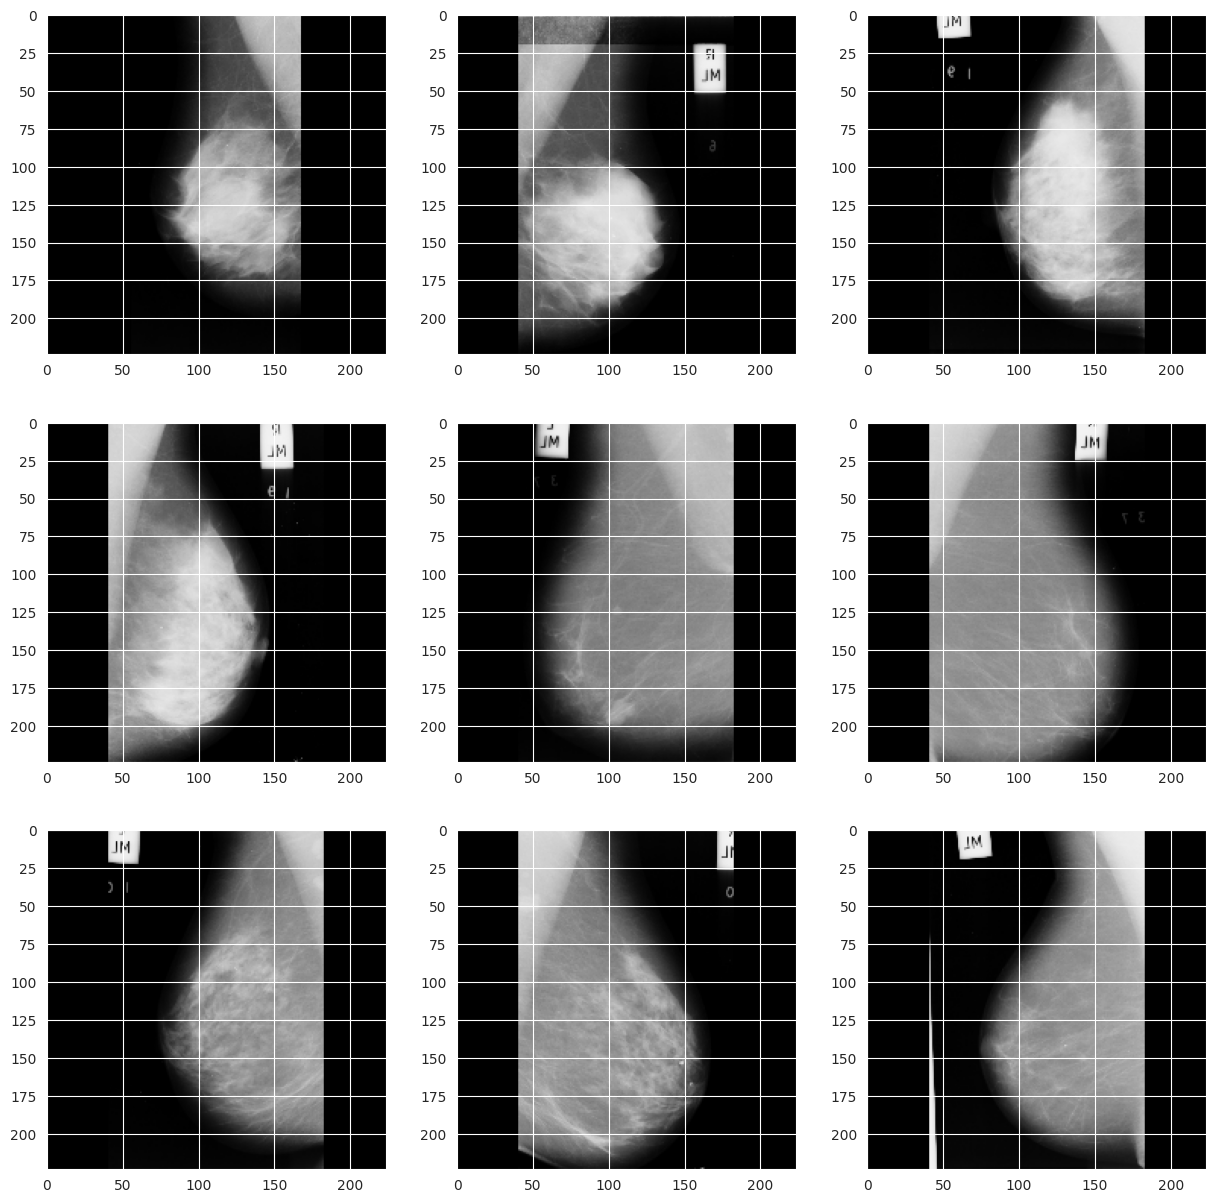

In [5]:
from PIL import Image
import glob
x= []
for filename in sorted(glob.glob("/content/drive/MyDrive/archive/all-mias/*.pgm")):
    img=cv2.imread(filename)
    img =cv2.resize(img,(224, 224))
    x.append(img)
fig=plt.figure(figsize=(15,15))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = np.random.randint(10)
    fig.add_subplot(rows, columns, i)
    plt.imshow(x[i])
plt.show()

In [6]:
# Image Augmentation
no_angles = 360
url = '/content/drive/MyDrive/archive/all-mias/'

def save_dictionary(path,data):
        print('saving catalog...')
        #open('u.item', encoding="utf-8")
        import json
        with open(path,'w') as outfile:
            json.dump(str(data), fp=outfile)
        # save to file:
        print(' catalog saved')

In [7]:
def read_image():
        print("Reading images")
        import cv2
        info = {}
        for i in range(322):
            if i<9:
                image_name='mdb00'+str(i+1)
            elif i<99:
                image_name='mdb0'+str(i+1)
            else:
                image_name = 'mdb' + str(i+1)
            image_address= url+image_name+'.pgm'
            img = cv2.imread(image_address,1)
            img = cv2.resize(img, (224,224))
            rows, cols,channel = img.shape
            info[image_name]={}
            for angle in range(0,no_angles,8):
                M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
                img_rotated = cv2.warpAffine(img, M, (cols, rows))
                info[image_name][angle]=img_rotated
        return (info)

In [8]:
def read_lable():
    print("Reading labels")
    filename = url+'Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')
        if len(words)>3:
            if (words[3] == 'B'):
                info[words[0]] = {}
                for angle in range(0,no_angles,8):
                    info[words[0]][angle] = 0
            if (words[3] == 'M'):
                info[words[0]] = {}
                for  angle in range(0,no_angles,8):
                    info[words[0]][angle] = 1
    return (info)

### Split data

In [9]:
import numpy as np
lable_info=read_lable()
image_info=read_image()
ids=lable_info.keys()
del lable_info['Truth-Data:']
X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,8):
        X.append(image_info[id][angle])
        Y.append(lable_info[id][angle])
X=np.array(X)
Y=np.array(Y)
Y=to_categorical(Y,2)
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42)
print(len(x_train),len(x_val),len(x_test))

Reading labels
Reading images
3622 1087 466


In [10]:
#Callbacks
c2=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

c3=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=6,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001
)
nClasses=3

In [11]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Helper function to preprocess the images using various techniques
def preprocess_image(image, techniques):
    if len(image.shape) == 3:
        # Convert the image to grayscale if it's in color (3 channels)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Check if the image is already in the correct format (grayscale)
    if image.dtype != np.uint8:
        # Convert 16-bit grayscale to 8-bit grayscale if needed
        image = cv2.convertScaleAbs(image)

    if 'CLAHE' in techniques:
        if len(np.unique(image)) == 1:
            # If the image is a uniform color (e.g., all black or all white), skip CLAHE
            return image
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image = clahe.apply(image)

    if 'MF' in techniques:
        image = cv2.medianBlur(image, 3)

    if 'USM' in techniques:
        blurred = cv2.GaussianBlur(image, (0, 0), 2.5)
        image = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)

    return image
# Split the data into train, validation, and test sets
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42)
# print(len(x_train), len(x_val), len(x_test))



## Classification using Ensemble Techniques

### SVM

In [12]:
# Preprocess the images using different combinations ESSAMBLE of techniques
techniques_combinations = [
    [],  # No preprocessing
    ['CLAHE'],
    ['MF'],
    ['USM'],
    ['CLAHE', 'MF'],
    ['CLAHE', 'USM'],
    ['MF', 'USM'],
    ['CLAHE', 'MF', 'USM']
]

for techniques in techniques_combinations:
    X_train_preprocessed = [preprocess_image(img, techniques) for img in x_train]
    X_test_preprocessed = [preprocess_image(img, techniques) for img in x_test]

    # Convert the preprocessed images to NumPy arrays and flatten them
    X_train_features = np.array([img.flatten() for img in X_train_preprocessed])
    X_test_features = np.array([img.flatten() for img in X_test_preprocessed])

    # Define Y_train and Y_test using the binary labels (0 or 1)
    Y_train_binary = y_train[:, 1]  # Select the second column which represents 'M' class
    Y_test_binary = y_test[:, 1]

    # Create SVM classifier and pipeline with StandardScaler
    svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='linear'))

    # Train the SVM classifier
    svm_classifier.fit(X_train_features, Y_train_binary)

    # Make predictions on the test set
    Y_pred = svm_classifier.predict(X_test_features)

    # Calculate evaluation metrics
    accuracy = accuracy_score(Y_test_binary, Y_pred)
    sensitivity = recall_score(Y_test_binary, Y_pred)
    specificity = recall_score(Y_test_binary, Y_pred, pos_label=0)
    ppv = precision_score(Y_test_binary, Y_pred)
    npv = recall_score(Y_test_binary, Y_pred, pos_label=0)
    auc = roc_auc_score(Y_test_binary, Y_pred)
    ba = (sensitivity + specificity) / 2
    f1 = f1_score(Y_test_binary, Y_pred)

    print(f"Techniques: {techniques}")
    print(f"Accuracy: {accuracy}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print(f"PPV: {ppv}")
    print(f"NPV: {npv}")
    print(f"AUC: {auc}")
    print(f"BA: {ba}")
    print(f"F1: {f1}")
    print("=============================")

Techniques: []
Accuracy: 0.5622317596566524
Sensitivity: 0.4975124378109453
Specificity: 0.6113207547169811
PPV: 0.49261083743842365
NPV: 0.6113207547169811
AUC: 0.5544165962639631
BA: 0.5544165962639632
F1: 0.49504950495049505
Techniques: ['CLAHE']
Accuracy: 0.5579399141630901
Sensitivity: 0.5024875621890548
Specificity: 0.6
PPV: 0.48792270531400966
NPV: 0.6
AUC: 0.5512437810945274
BA: 0.5512437810945274
F1: 0.4950980392156863
Techniques: ['MF']
Accuracy: 0.555793991416309
Sensitivity: 0.5124378109452736
Specificity: 0.5886792452830188
PPV: 0.4858490566037736
NPV: 0.5886792452830188
AUC: 0.5505585281141462
BA: 0.5505585281141463
F1: 0.49878934624697335
Techniques: ['USM']
Accuracy: 0.5643776824034334
Sensitivity: 0.4975124378109453
Specificity: 0.6150943396226415
PPV: 0.49504950495049505
NPV: 0.6150943396226415
AUC: 0.5563033887167933
BA: 0.5563033887167934
F1: 0.49627791563275436
Techniques: ['CLAHE', 'MF']
Accuracy: 0.5450643776824035
Sensitivity: 0.4975124378109453
Specificity: 0.5

### RF

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Preprocess the images using different essamble combinations of techniques
techniques_combinations = [
    [],  # No preprocessing
    ['CLAHE'],
    ['MF'],
    ['USM'],
    ['CLAHE', 'MF'],
    ['CLAHE', 'USM'],
    ['MF', 'USM'],
    ['CLAHE', 'MF', 'USM']
]

for techniques in techniques_combinations:
    X_train_preprocessed = [preprocess_image(img, techniques) for img in x_train]
    X_test_preprocessed = [preprocess_image(img, techniques) for img in x_test]

    # Convert the preprocessed images to NumPy arrays and flatten them
    X_train_features = np.array([img.flatten() for img in X_train_preprocessed])
    X_test_features = np.array([img.flatten() for img in X_test_preprocessed])

    # Define Y_train and Y_test using the binary labels (0 or 1)
    Y_train_binary = y_train[:, 1]  # Select the second column which represents 'M' class
    Y_test_binary = y_test[:, 1]

    # Create and train the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train_features, Y_train_binary)

    # Make predictions on the test set
    Y_pred = rf_classifier.predict(X_test_features)

    # Calculate evaluation metrics
    accuracy = accuracy_score(Y_test_binary, Y_pred)
    sensitivity = recall_score(Y_test_binary, Y_pred, average='weighted')
    specificity = recall_score(Y_test_binary, Y_pred, average='weighted', pos_label=0)
    ppv = precision_score(Y_test_binary, Y_pred, average='weighted')
    npv = recall_score(Y_test_binary, Y_pred, average='weighted', pos_label=0)
    auc = roc_auc_score(Y_test_binary, Y_pred, average='weighted')
    ba = (sensitivity + specificity) / 2
    f1 = f1_score(Y_test_binary, Y_pred, average='weighted')

    print(f"Techniques: {techniques}")
    print(f"Accuracy: {accuracy}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print(f"PPV: {ppv}")
    print(f"NPV: {npv}")
    print(f"AUC: {auc}")
    print(f"BA: {ba}")
    print(f"F1: {f1}")
    print("=============================")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Techniques: []
Accuracy: 0.907725321888412
Sensitivity: 0.907725321888412
Specificity: 0.907725321888412
PPV: 0.9086363501513024
NPV: 0.907725321888412
AUC: 0.9014456021777904
BA: 0.907725321888412
F1: 0.9072068879526455


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Techniques: ['CLAHE']
Accuracy: 0.8433476394849786
Sensitivity: 0.8433476394849786
Specificity: 0.8433476394849786
PPV: 0.8482703345571124
NPV: 0.8433476394849786
AUC: 0.8298225851872713
BA: 0.8433476394849786
F1: 0.8407299045415986


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Techniques: ['MF']
Accuracy: 0.9141630901287554
Sensitivity: 0.9141630901287554
Specificity: 0.9141630901287554
PPV: 0.914249107871381
NPV: 0.9141630901287554
AUC: 0.9101098282174036
BA: 0.9141630901287554
F1: 0.9139298420578505


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Techniques: ['USM']
Accuracy: 0.8819742489270386
Sensitivity: 0.8819742489270386
Specificity: 0.8819742489270386
PPV: 0.883705743469692
NPV: 0.8819742489270386
AUC: 0.8733971651178072
BA: 0.8819742489270386
F1: 0.8809707003055142


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Techniques: ['CLAHE', 'MF']
Accuracy: 0.871244635193133
Sensitivity: 0.871244635193133
Specificity: 0.871244635193133
PPV: 0.8789287496642447
NPV: 0.871244635193133
AUC: 0.8573547357551864
BA: 0.871244635193133
F1: 0.8688308457546203


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Techniques: ['CLAHE', 'USM']
Accuracy: 0.7746781115879828
Sensitivity: 0.7746781115879828
Specificity: 0.7746781115879828
PPV: 0.7810935789214706
NPV: 0.7746781115879828
AUC: 0.7556275227635407
BA: 0.7746781115879828
F1: 0.7685739694647689


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Techniques: ['MF', 'USM']
Accuracy: 0.8948497854077253
Sensitivity: 0.8948497854077253
Specificity: 0.8948497854077253
PPV: 0.8980367161327647
NPV: 0.8948497854077253
AUC: 0.8853186895710128
BA: 0.8948497854077253
F1: 0.8937316205334556
Techniques: ['CLAHE', 'MF', 'USM']
Accuracy: 0.8025751072961373
Sensitivity: 0.8025751072961373
Specificity: 0.8025751072961373
PPV: 0.811837336664668
NPV: 0.8025751072961373
AUC: 0.7837604430676804
BA: 0.8025751072961373
F1: 0.7970631466358119


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


### KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score

# Preprocess the images using essemble different combinations of techniques
techniques_combinations = [
    [],  # No preprocessing
    ['CLAHE'],
    ['MF'],
    ['USM'],
    ['CLAHE', 'MF'],
    ['CLAHE', 'USM'],
    ['MF', 'USM'],
    ['CLAHE', 'MF', 'USM']
]

for techniques in techniques_combinations:
    X_train_preprocessed = [preprocess_image(img, techniques) for img in x_train]
    X_test_preprocessed = [preprocess_image(img, techniques) for img in x_test]

    # Convert the preprocessed images to NumPy arrays and flatten them
    X_train_features = np.array([img.flatten() for img in X_train_preprocessed])
    X_test_features = np.array([img.flatten() for img in X_test_preprocessed])

    # Define Y_train and Y_test using the binary labels (0 or 1)
    Y_train_binary = y_train[:, 1]  # Select the second column which represents 'M' class
    Y_test_binary = y_test[:, 1]

    # Create kNN classifier with k=5
    knn_classifier = KNeighborsClassifier(n_neighbors=5)

    # Train the kNN classifier
    knn_classifier.fit(X_train_features, Y_train_binary)

    # Make predictions on the test set
    Y_pred = knn_classifier.predict(X_test_features)

    # Calculate evaluation metrics
    accuracy = accuracy_score(Y_test_binary, Y_pred)
    sensitivity = recall_score(Y_test_binary, Y_pred)
    specificity = recall_score(Y_test_binary, Y_pred, pos_label=0)
    ppv = precision_score(Y_test_binary, Y_pred)
    npv = recall_score(Y_test_binary, Y_pred, pos_label=0)
    auc = roc_auc_score(Y_test_binary, Y_pred)
    ba = (sensitivity + specificity) / 2
    f1 = f1_score(Y_test_binary, Y_pred)

    print(f"Techniques: {techniques}")
    print(f"Accuracy: {accuracy}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print(f"PPV: {ppv}")
    print(f"NPV: {npv}")
    print(f"AUC: {auc}")
    print(f"BA: {ba}")
    print(f"F1: {f1}")
    print("=============================")


Techniques: []
Accuracy: 0.628755364806867
Sensitivity: 0.4925373134328358
Specificity: 0.7320754716981132
PPV: 0.5823529411764706
NPV: 0.7320754716981132
AUC: 0.6123063925654745
BA: 0.6123063925654745
F1: 0.5336927223719676
Techniques: ['CLAHE']
Accuracy: 0.6394849785407726
Sensitivity: 0.4975124378109453
Specificity: 0.7471698113207547
PPV: 0.5988023952095808
NPV: 0.7471698113207547
AUC: 0.62234112456585
BA: 0.62234112456585
F1: 0.5434782608695651
Techniques: ['MF']
Accuracy: 0.6244635193133047
Sensitivity: 0.48258706467661694
Specificity: 0.7320754716981132
PPV: 0.5773809523809523
NPV: 0.7320754716981132
AUC: 0.6073312681873652
BA: 0.607331268187365
F1: 0.5257452574525746
Techniques: ['USM']
Accuracy: 0.6223175965665236
Sensitivity: 0.4975124378109453
Specificity: 0.7169811320754716
PPV: 0.5714285714285714
NPV: 0.7169811320754716
AUC: 0.6072467849432086
BA: 0.6072467849432085
F1: 0.5319148936170213
Techniques: ['CLAHE', 'MF']
Accuracy: 0.6394849785407726
Sensitivity: 0.4975124378109

### DT

In [15]:
from sklearn.tree import DecisionTreeClassifier

# Preprocess the images using essamble different combinations of techniques
techniques_combinations = [
    [],  # No preprocessing
    ['CLAHE'],
    ['MF'],
    ['USM'],
    ['CLAHE', 'MF'],
    ['CLAHE', 'USM'],
    ['MF', 'USM'],
    ['CLAHE', 'MF', 'USM']
]

for techniques in techniques_combinations:
    X_train_preprocessed = [preprocess_image(img, techniques) for img in x_train]
    X_test_preprocessed = [preprocess_image(img, techniques) for img in x_test]

    # Convert the preprocessed images to NumPy arrays and flatten them
    X_train_features = np.array([img.flatten() for img in X_train_preprocessed])
    X_test_features = np.array([img.flatten() for img in X_test_preprocessed])

    # Define Y_train and Y_test using the binary labels (0 or 1)
    Y_train_binary = y_train[:, 1]  # Select the second column which represents 'M' class
    Y_test_binary = y_test[:, 1]

    # Create Decision Tree classifier
    dt_classifier = DecisionTreeClassifier()

    # Train the Decision Tree classifier
    dt_classifier.fit(X_train_features, Y_train_binary)

    # Make predictions on the test set
    Y_pred = dt_classifier.predict(X_test_features)

    # Calculate evaluation metrics
    accuracy = accuracy_score(Y_test_binary, Y_pred)
    sensitivity = recall_score(Y_test_binary, Y_pred)
    specificity = recall_score(Y_test_binary, Y_pred, pos_label=0)
    ppv = precision_score(Y_test_binary, Y_pred)
    npv = recall_score(Y_test_binary, Y_pred, pos_label=0)
    auc = roc_auc_score(Y_test_binary, Y_pred)
    ba = (sensitivity + specificity) / 2
    f1 = f1_score(Y_test_binary, Y_pred)

    print(f"Techniques: {techniques}")
    print(f"Accuracy: {accuracy}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print(f"PPV: {ppv}")
    print(f"NPV: {npv}")
    print(f"AUC: {auc}")
    print(f"BA: {ba}")
    print(f"F1: {f1}")
    print("=============================")


Techniques: []
Accuracy: 0.8025751072961373
Sensitivity: 0.7711442786069652
Specificity: 0.8264150943396227
PPV: 0.7711442786069652
NPV: 0.8264150943396227
AUC: 0.7987796864732939
BA: 0.7987796864732939
F1: 0.7711442786069652
Techniques: ['CLAHE']
Accuracy: 0.7167381974248928
Sensitivity: 0.6666666666666666
Specificity: 0.7547169811320755
PPV: 0.6733668341708543
NPV: 0.7547169811320755
AUC: 0.710691823899371
BA: 0.7106918238993711
F1: 0.67
Techniques: ['MF']
Accuracy: 0.8626609442060086
Sensitivity: 0.8507462686567164
Specificity: 0.8716981132075472
PPV: 0.8341463414634146
NPV: 0.8716981132075472
AUC: 0.8612221909321318
BA: 0.8612221909321318
F1: 0.8423645320197045
Techniques: ['USM']
Accuracy: 0.7982832618025751
Sensitivity: 0.7213930348258707
Specificity: 0.8566037735849057
PPV: 0.7923497267759563
NPV: 0.8566037735849057
AUC: 0.7889984042053881
BA: 0.7889984042053881
F1: 0.7552083333333333
Techniques: ['CLAHE', 'MF']
Accuracy: 0.7339055793991416
Sensitivity: 0.7164179104477612
Specif

### NB

In [16]:
from sklearn.naive_bayes import GaussianNB

# Preprocess the images using different combinations of techniques
techniques_combinations = [
    [],  # No preprocessing
    ['CLAHE'],
    ['MF'],
    ['USM'],
    ['CLAHE', 'MF'],
    ['CLAHE', 'USM'],
    ['MF', 'USM'],
    ['CLAHE', 'MF', 'USM']
]

for techniques in techniques_combinations:
    X_train_preprocessed = [preprocess_image(img, techniques) for img in x_train]
    X_test_preprocessed = [preprocess_image(img, techniques) for img in x_test]

    # Convert the preprocessed images to NumPy arrays and flatten them
    X_train_features = np.array([img.flatten() for img in X_train_preprocessed])
    X_test_features = np.array([img.flatten() for img in X_test_preprocessed])

    # Define Y_train and Y_test using the binary labels (0 or 1)
    Y_train_binary = y_train[:, 1]  # Select the second column which represents 'M' class
    Y_test_binary = y_test[:, 1]

    # Create Gaussian Naive Bayes classifier
    nb_classifier = GaussianNB()

    # Train the Naive Bayes classifier
    nb_classifier.fit(X_train_features, Y_train_binary)

    # Make predictions on the test set
    Y_pred = nb_classifier.predict(X_test_features)

    # Calculate evaluation metrics
    accuracy = accuracy_score(Y_test_binary, Y_pred)
    sensitivity = recall_score(Y_test_binary, Y_pred)
    specificity = recall_score(Y_test_binary, Y_pred, pos_label=0)
    ppv = precision_score(Y_test_binary, Y_pred)
    npv = recall_score(Y_test_binary, Y_pred, pos_label=0)
    auc = roc_auc_score(Y_test_binary, Y_pred)
    ba = (sensitivity + specificity) / 2
    f1 = f1_score(Y_test_binary, Y_pred)

    print(f"Techniques: {techniques}")
    print(f"Accuracy: {accuracy}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print(f"PPV: {ppv}")
    print(f"NPV: {npv}")
    print(f"AUC: {auc}")
    print(f"BA: {ba}")
    print(f"F1: {f1}")
    print("=============================")


Techniques: []
Accuracy: 0.43776824034334766
Sensitivity: 0.8557213930348259
Specificity: 0.12075471698113208
PPV: 0.4246913580246914
NPV: 0.12075471698113208
AUC: 0.48823805500797895
BA: 0.48823805500797895
F1: 0.5676567656765676
Techniques: ['CLAHE']
Accuracy: 0.4334763948497854
Sensitivity: 0.900497512437811
Specificity: 0.07924528301886792
PPV: 0.4258823529411765
NPV: 0.07924528301886792
AUC: 0.48987139772833943
BA: 0.48987139772833943
F1: 0.5782747603833867
Techniques: ['MF']
Accuracy: 0.43991416309012876
Sensitivity: 0.8557213930348259
Specificity: 0.12452830188679245
PPV: 0.42574257425742573
NPV: 0.12452830188679245
AUC: 0.49012484746080914
BA: 0.49012484746080914
F1: 0.568595041322314
Techniques: ['USM']
Accuracy: 0.43991416309012876
Sensitivity: 0.8507462686567164
Specificity: 0.12830188679245283
PPV: 0.4253731343283582
NPV: 0.12830188679245283
AUC: 0.4895240777245846
BA: 0.4895240777245846
F1: 0.5671641791044776
Techniques: ['CLAHE', 'MF']
Accuracy: 0.4334763948497854
Sensiti

### ANN

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Preprocess the images using different combinations of techniques
techniques_combinations = [
    [],  # No preprocessing
    ['CLAHE'],
    ['MF'],
    ['USM'],
    ['CLAHE', 'MF'],
    ['CLAHE', 'USM'],
    ['MF', 'USM'],
    ['CLAHE', 'MF', 'USM']
]

for techniques in techniques_combinations:
    X_train_preprocessed = [preprocess_image(img, techniques) for img in x_train]
    X_test_preprocessed = [preprocess_image(img, techniques) for img in x_test]

    # Convert the preprocessed images to NumPy arrays
    X_train_features = np.array(X_train_preprocessed)
    X_test_features = np.array(X_test_preprocessed)

    # Define Y_train and Y_test using the binary labels (0 or 1)
    Y_train_binary = y_train[:, 1]  # Select the second column which represents 'M' class
    Y_test_binary = y_test[:, 1]

    # Create a sequential model
    model = Sequential([
        Flatten(input_shape=X_train_features.shape[1:]),  # Flatten the input
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_features, Y_train_binary, epochs=10, batch_size=32, validation_data=(X_test_features, Y_test_binary))

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test_features, Y_test_binary)

    # Make predictions using the trained model
    Y_pred = model.predict(X_test_features)
    Y_pred_binary = (Y_pred > 0.5).astype(int)


    # Generate the classification report
    class_report = classification_report(Y_test_binary, Y_pred_binary)

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test_features, Y_test_binary)
    print(f"Techniques: {techniques}")
    print(f"Test Accuracy: {accuracy}")
    print("Classification Report:")
    print(class_report)
    print("=============================")


Epoch 1/10
114/114 [==============================] - 16s 128ms/step - loss: 248.3097 - accuracy: 0.5086 - val_loss: 0.9209 - val_accuracy: 0.5665
Epoch 2/10
114/114 [==============================] - 12s 104ms/step - loss: 1.6206 - accuracy: 0.5425 - val_loss: 0.9179 - val_accuracy: 0.5665
Epoch 3/10
114/114 [==============================] - 12s 102ms/step - loss: 0.8248 - accuracy: 0.5414 - val_loss: 0.7084 - val_accuracy: 0.5687
Epoch 4/10
114/114 [==============================] - 11s 97ms/step - loss: 0.6927 - accuracy: 0.5417 - val_loss: 0.7076 - val_accuracy: 0.5687
Epoch 5/10
114/114 [==============================] - 13s 113ms/step - loss: 0.6920 - accuracy: 0.5420 - val_loss: 0.7071 - val_accuracy: 0.5687
Epoch 6/10
114/114 [==============================] - 12s 106ms/step - loss: 0.7055 - accuracy: 0.5417 - val_loss: 0.6861 - val_accuracy: 0.5687
Epoch 7/10
114/114 [==============================] - 12s 101ms/step - loss: 0.6899 - accuracy: 0.5417 - val_loss: 0.6858 - val_a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 27ms/step - loss: 0.6854 - accuracy: 0.5687
Techniques: []
Test Accuracy: 0.5686695575714111
Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       265
         1.0       0.00      0.00      0.00       201

    accuracy                           0.57       466
   macro avg       0.28      0.50      0.36       466
weighted avg       0.32      0.57      0.41       466

Epoch 1/10
114/114 [==============================] - 14s 118ms/step - loss: 232.2711 - accuracy: 0.5378 - val_loss: 0.6905 - val_accuracy: 0.5687
Epoch 2/10
114/114 [==============================] - 12s 108ms/step - loss: 0.6908 - accuracy: 0.5422 - val_loss: 0.6882 - val_accuracy: 0.5687
Epoch 3/10
114/114 [==============================] - 12s 101ms/step - loss: 0.6956 - accuracy: 0.5417 - val_loss: 0.6870 - val_accuracy: 0.5687
Epoch 4/10
114/114 [==============================] - 11s 98ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 15ms/step - loss: 0.6855 - accuracy: 0.5687
Techniques: ['CLAHE']
Test Accuracy: 0.5686695575714111
Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       265
         1.0       0.00      0.00      0.00       201

    accuracy                           0.57       466
   macro avg       0.28      0.50      0.36       466
weighted avg       0.32      0.57      0.41       466

Epoch 1/10
114/114 [==============================] - 14s 109ms/step - loss: 204.7199 - accuracy: 0.5257 - val_loss: 0.6902 - val_accuracy: 0.5687
Epoch 2/10
114/114 [==============================] - 11s 99ms/step - loss: 0.7284 - accuracy: 0.5422 - val_loss: 0.6879 - val_accuracy: 0.5687
Epoch 3/10
114/114 [==============================] - 12s 107ms/step - loss: 0.6928 - accuracy: 0.5420 - val_loss: 0.6868 - val_accuracy: 0.5687
Epoch 4/10
114/114 [==============================] - 12s 109ms/step -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 19ms/step - loss: 0.6852 - accuracy: 0.5687
Techniques: ['MF']
Test Accuracy: 0.5686695575714111
Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       265
         1.0       0.00      0.00      0.00       201

    accuracy                           0.57       466
   macro avg       0.28      0.50      0.36       466
weighted avg       0.32      0.57      0.41       466

Epoch 1/10
114/114 [==============================] - 14s 114ms/step - loss: 264.4523 - accuracy: 0.5218 - val_loss: 0.8166 - val_accuracy: 0.5794
Epoch 2/10
114/114 [==============================] - 12s 107ms/step - loss: 1.2018 - accuracy: 0.5425 - val_loss: 0.7775 - val_accuracy: 0.5687
Epoch 3/10
114/114 [==============================] - 12s 101ms/step - loss: 0.8603 - accuracy: 0.5420 - val_loss: 0.6876 - val_accuracy: 0.5687
Epoch 4/10
114/114 [==============================] - 11s 95ms/step - lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 16ms/step - loss: 0.6854 - accuracy: 0.5687
Techniques: ['USM']
Test Accuracy: 0.5686695575714111
Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       265
         1.0       0.00      0.00      0.00       201

    accuracy                           0.57       466
   macro avg       0.28      0.50      0.36       466
weighted avg       0.32      0.57      0.41       466

Epoch 1/10
114/114 [==============================] - 15s 115ms/step - loss: 231.5278 - accuracy: 0.5246 - val_loss: 0.6907 - val_accuracy: 0.5708
Epoch 2/10
114/114 [==============================] - 13s 112ms/step - loss: 0.8580 - accuracy: 0.5422 - val_loss: 0.6889 - val_accuracy: 0.5687
Epoch 3/10
114/114 [==============================] - 14s 121ms/step - loss: 0.6996 - accuracy: 0.5420 - val_loss: 0.6875 - val_accuracy: 0.5687
Epoch 4/10
114/114 [==============================] - 23s 200ms/step - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 16ms/step - loss: 0.6855 - accuracy: 0.5687
Techniques: ['CLAHE', 'MF']
Test Accuracy: 0.5686695575714111
Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       265
         1.0       0.00      0.00      0.00       201

    accuracy                           0.57       466
   macro avg       0.28      0.50      0.36       466
weighted avg       0.32      0.57      0.41       466

Epoch 1/10
114/114 [==============================] - 13s 108ms/step - loss: 256.5431 - accuracy: 0.5229 - val_loss: 0.6909 - val_accuracy: 0.5687
Epoch 2/10
114/114 [==============================] - 12s 103ms/step - loss: 0.6949 - accuracy: 0.5417 - val_loss: 0.6884 - val_accuracy: 0.5687
Epoch 3/10
114/114 [==============================] - 12s 109ms/step - loss: 0.7001 - accuracy: 0.5417 - val_loss: 0.6870 - val_accuracy: 0.5687
Epoch 4/10
114/114 [==============================] - 12s 102ms

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 35ms/step - loss: 0.6851 - accuracy: 0.5687
Techniques: ['CLAHE', 'USM']
Test Accuracy: 0.5686695575714111
Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       265
         1.0       0.00      0.00      0.00       201

    accuracy                           0.57       466
   macro avg       0.28      0.50      0.36       466
weighted avg       0.32      0.57      0.41       466

Epoch 1/10
114/114 [==============================] - 22s 168ms/step - loss: 264.1802 - accuracy: 0.5312 - val_loss: 0.6897 - val_accuracy: 0.5687
Epoch 2/10
114/114 [==============================] - 12s 106ms/step - loss: 0.7404 - accuracy: 0.5422 - val_loss: 0.6874 - val_accuracy: 0.5687
Epoch 3/10
114/114 [==============================] - 12s 106ms/step - loss: 0.6890 - accuracy: 0.5433 - val_loss: 0.6863 - val_accuracy: 0.5687
Epoch 4/10
114/114 [==============================] - 12s 103m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 19ms/step - loss: 0.6853 - accuracy: 0.5687
Techniques: ['MF', 'USM']
Test Accuracy: 0.5686695575714111
Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       265
         1.0       0.00      0.00      0.00       201

    accuracy                           0.57       466
   macro avg       0.28      0.50      0.36       466
weighted avg       0.32      0.57      0.41       466

Epoch 1/10
114/114 [==============================] - 13s 104ms/step - loss: 271.4888 - accuracy: 0.5345 - val_loss: 0.6897 - val_accuracy: 0.5708
Epoch 2/10
114/114 [==============================] - 12s 102ms/step - loss: 0.6927 - accuracy: 0.5422 - val_loss: 0.6874 - val_accuracy: 0.5708
Epoch 3/10
114/114 [==============================] - 11s 99ms/step - loss: 0.6904 - accuracy: 0.5422 - val_loss: 0.6861 - val_accuracy: 0.5708
Epoch 4/10
114/114 [==============================] - 10s 88ms/ste

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 26ms/step - loss: 0.6853 - accuracy: 0.5687
Techniques: ['CLAHE', 'MF', 'USM']
Test Accuracy: 0.5686695575714111
Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       265
         1.0       0.00      0.00      0.00       201

    accuracy                           0.57       466
   macro avg       0.28      0.50      0.36       466
weighted avg       0.32      0.57      0.41       466

